In [81]:
!pip install pandas numpy seaborn scikit-learn xgboost matplotlib tk


In [82]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
from tkinter import *


In [83]:
# Read CSV files
def read_csv(file_path):
    return pd.read_csv(file_path)

# Load the datasets
calories = read_csv('calories.csv')
exercise = read_csv('exercise.csv')

# Merge datasets
data = pd.merge(calories, exercise, on='User_ID')

# Display the first few rows
data.head()


,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [84]:
# Display dataset info and basic statistics
def dataset_info_statistics(data):
    print("Dataset Information:")
    print(data.info())
    print("\nBasic Statistics for Numerical Columns:")
    print(data.describe())

dataset_info_statistics(data)

# Check for null values
def check_null(data):
    null_counts = data.isnull().sum()
    print("Null Values in the Dataset:")
    return null_counts

check_null(data)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB
None

Basic Statistics for Numerical Columns:
            User_ID      Calories           Age        Height        Weight  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     89.539533     42.789800    174.465133     74.966867   
std    2.872851e+06     62.456978     16.980264     14.258114     15.035657

User_ID       0
Calories      0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

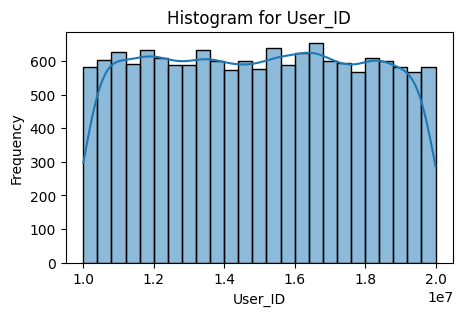

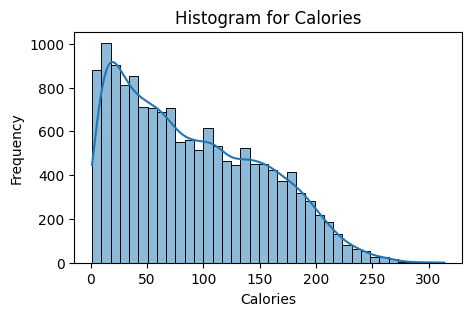

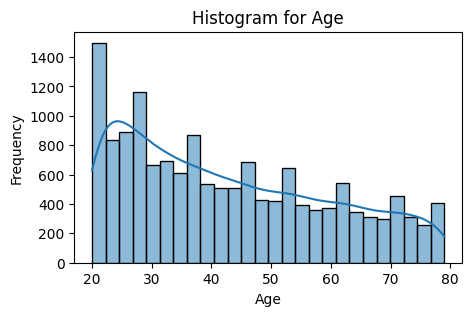

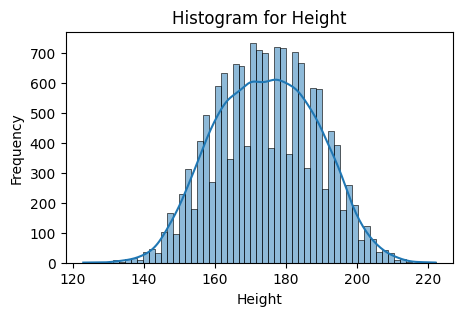

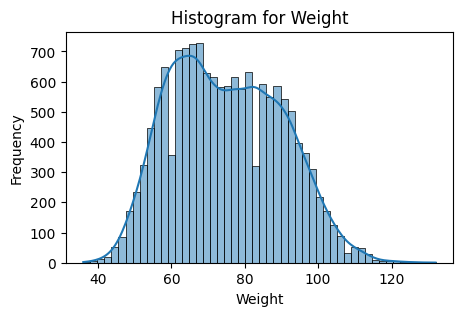

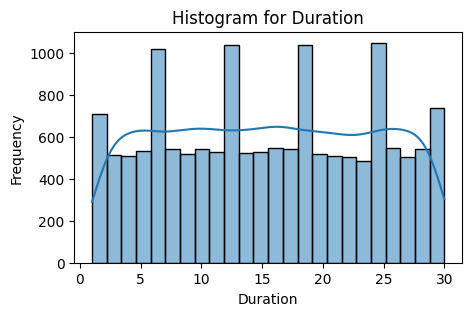

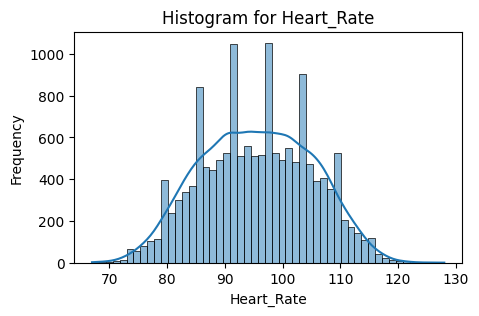

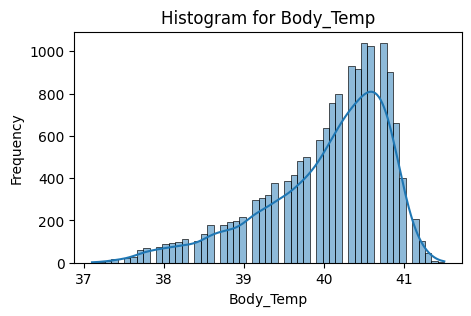

ValueError: could not convert string to float: 'male'

<Figure size 500x300 with 0 Axes>

In [85]:
def plot_graph(data):
    # Plotting numerical data
    numerical_columns = data.select_dtypes(include=np.number).columns
    for column in numerical_columns:
        plt.figure(figsize=(5,3))
        sns.histplot(data[column], kde=True)
        plt.title(f"Histogram for {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

    # Plotting categorical data
    categorical_columns = data.select_dtypes(include='object').columns
    for column in categorical_columns:
        plt.figure(figsize=(5, 3))
        sns.countplot(data[column])
        plt.title(f'Countplot for {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

plot_graph(data)



In [86]:
def separate_features_target(data, target_column):
    X = data.drop(columns=[target_column], axis=1)
    y = data[target_column]
    return X, y

X, y = separate_features_target(data, 'Calories')
X = X.drop(columns=['User_ID'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [87]:

from sklearn import set_config
set_config(display='diagram')

# Preprocessor with ordinal encoding for 'Gender' and standard scaling for numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(), ['Gender']),
    ('num', StandardScaler(), ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'])
], remainder='passthrough')

# Create the pipeline with linear regression model
pipeline = Pipeline([("preprocessor", preprocessor),
                     ("model", LinearRegression())])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
r2_score(y_test, y_pred)


0.9672937151257295

In [88]:

# KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')

cv_results.mean()


0.9671402283675841

In [89]:
def model_scorer(model_name, model):
    output = []
    output.append(model_name)
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    output.append(r2_score(y_test, y_pred))
    output.append(mean_absolute_error(y_test, y_pred))
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
    output.append(cv_results.mean())
    return output

model_dict = {
    'log': LinearRegression(),
    'RF': RandomForestRegressor(),
    'XGBR': XGBRegressor(),
}

model_output = []
for model_name, model in model_dict.items():
    model_output.append(model_scorer(model_name, model))

model_output


[['log', 0.9672937151257295, 8.441513553849704, 0.9671402283675841],
 ['RF', 0.9982472955536988, 1.7001333333333333, 0.997922505972397],
 ['XGBR', 0.9987522347821293, 1.5171571099360783, 0.9987673407571723]]

In [90]:
# Save the model pipeline
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Load the saved model
with open('pipeline.pkl', 'rb') as f:
    pipeline_saved = pickle.load(f)


In [ ]:
def show_entry():
    with open('pipeline.pkl', 'rb') as f:
        pipeline = pickle.load(f)

    # Get input from the user
    p1 = str(clicked.get())  # Gender (string)
    p2 = float(e2.get())     # Age (float)
    p3 = float(e3.get())     # Height (float)
    p4 = float(e4.get())     # Weight (float)
    p5 = float(e5.get())     # Duration (float)
    p6 = float(e6.get())     # Heart Rate (float)
    p7 = float(e7.get())     # Body Temp (float)

    # Create the sample DataFrame for prediction
    sample = pd.DataFrame({
        'Gender': [p1],
        'Age': [p2],
        'Height': [p3],
        'Weight': [p4],
        'Duration': [p5],
        'Heart_Rate': [p6],
        'Body_Temp': [p7],
    })

    # Make prediction using the model
    result = pipeline.predict(sample)
    
    # Display the result in the GUI
    Label(master, text="Amount of Calories Burnt").grid(row=13)
    Label(master, text=f"{result[0]:.2f} calories").grid(row=14)

# Tkinter GUI setup
master = Tk()
master.title("Calories Burnt Prediction using Machine Learning")

Label(master, text="Calories Burnt Prediction", bg="black", fg="white").grid(row=0, columnspan=2)
Label(master, text="Select Gender").grid(row=1)
Label(master, text="Enter Your Age").grid(row=2)
Label(master, text="Enter Your Height").grid(row=3)
Label(master, text="Enter Your Weight").grid(row=4)
Label(master, text="Duration").grid(row=5)
Label(master, text="Heart Rate").grid(row=6)
Label(master, text="Body Temp").grid(row=7)

clicked = StringVar()
options = ['male', 'female']

e1 = OptionMenu(master, clicked, *options)
e1.configure(width=15)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)
e7 = Entry(master)

e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)
e7.grid(row=7, column=1)

Button(master, text="Predict", command=show_entry).grid()

mainloop()
